In [1]:
q = 0x40000000000000000000000000000000224698fc0994a8dd8c46eb2100000001
K = GF(q)
P.<X> = K[]

In [2]:
p = 0x1a0111ea397fe69a4b1ba7b6434bacd764774b84f38512bf6730d2a0f6b0f6241eabfffeb153ffffb9feffffffffaaab
Kk = GF(p)
ak = Kk(0x00)
bk = Kk(0x04)
E = EllipticCurve(Kk, (ak, bk))

# Generators which form the curve pairing
g1 = 0x17F1D3A73197D7942695638C4FA9AC0FC3688C4F9774B905A14E3A3F171BAC586C55E83FF97A1AEFFB3AF00ADB22C6BB
g2 = 0x08B3F481E3AAA0F1A09E30ED741D8AE4FCF5E095D5D00AF600DB18CB2C04B3EDD03CC744A2888AE40CAA232946C5E7E1

G = E(g1, g2)
E.set_order(0x73EDA753299D7D483339D80809A1D80553BDA402FFFE5BFEFFFFFFFF00000001 * 0x396C8C005555E1568C00AAAB0000AAAB)

## Trusted Setup

Plonk requires a random seed x, which cannot be known by either the verifier or the prover. The method for generating the "toxic waste" x is outside the scope of plonk. For discussion purposes consider a trusted third party which generates x, constructs the structured reference string (SRS)from x and then discards x so that no one knows it.

The SRS is a list of powers of x multiplied by the two generator points

$ x^0g_1, x^1g_1, ..., x^{n+5}g_1 $

$ x^0g_2, x^1g_2, ..., x^{n+5}g_2 $

In [3]:
#n = 64

#x = K.random_element()
#xs_1 = [x^i*g1 for i in range(n+5)]
#xs_2 = [x^i*g2 for i in range(n+5)]

## Indexing Polynomials

In a computer we index into arrays with an offset i. In math, polynomials are used like arrays. To use a polynomial like an array, you could encode the polynomial p, so that p(i) = v\[i\]. 

*TODO: Why are roots of unity needed?*

PLONK uses a polynomial called L_i(x) which is defined so that L_i(w^i) = 1, and 0 for all other roots of unity. See the definition of L at the beginning of section 5 in the PLONK paper.

## Deriving The Roots of Unity

The field in plonk is chosen so that the multiplicative group has a subgroup of order $2^{32}$. 

The field also has a prime order, denoted $GF(q)$, which means the order of the multiplicative group is q-1 [from wikipedia](https://en.wikipedia.org/wiki/Finite_field#Multiplicative_structure).

To derive the nth roots of unity where n is $2^{32}$, take the generator of the multiplicative group of $GF(q)$, call it g, and raise g to the power $(q-1)/2^{32}$. Remember q-1 is the order of the group which g generates. So $g^{q-1} = 1$. To see what happens when you divide the order of a subgroup by the order of the group, first we should simplify terms; $m=q-1, k=2^{32}$.

Consider the order of the group generated by $|<g^{m/k}>|$

When multiplied by k, $g^{m/k^k} = g^m = 1$. Therefore the order of the generated group must be k since the generator applied k times is 1. This is how we derive the generator for the $2^{32}$ roots of unity, called $\omega$. Raise the generator g to the order $g^{m/k}$.

In [4]:
# Get the generator for the nth roots of unity
#def omega(n):
#    g = K.multiplicative_generator()
#    t = (q-1)/n
#    return g^t

# This example needs only a group size of 8 since the circuit length is less than 8
#omega = omega(n)
#print(omega)


In [5]:
# Generates a table from a parsed expr tree
def to_table(node):
    # Tuples of (a, b, c, q_l, q_r, q_o, q_m, q_c)
    table = []

    if type(t := node) == tuple:
        (op, a, b) = t
        # Recurse
        if ta := to_table(a):
            table += ta
        if tb := to_table(b):
            table += tb

        # Add top level
        if op == '+':
                a = evaluate(a)
                b = evaluate(b)
                table.append((a,b,a+b,1,1,-1,0,0))
        if op == '*':
                a = evaluate(a)
                b = evaluate(b)
                table.append((a,b,a*b,0,0,-1,1,0))

    return table

# Execute a program and return its value
def evaluate(node):
    if type(t := node) == tuple:
        (op, a, b) = t
        a = evaluate(a)
        b = evaluate(b)
        if op == '+': return a+b
        if op == '*': return a*b
    return node

# Generate the q and permutation polynomials in the preprocess step
def preprocess(table):
    a =  [row[0] for row in table]
    b =  [row[1] for row in table]
    c =  [row[2] for row in table]
    ql = [row[3] for row in table]
    qr = [row[4] for row in table]
    qo = [row[5] for row in table]
    qm = [row[6] for row in table]
    qc = [row[7] for row in table]

    #Ql = P.lagrange_polynomial((omega^i, ql_i) for i, ql_i in enumerate(ql))
    #Qr = P.lagrange_polynomial((omega^i, qr_i) for i, qr_i in enumerate(qr))
    #Qo = P.lagrange_polynomial((omega^i, qo_i) for i, qo_i in enumerate(qo))
    #Qm = P.lagrange_polynomial((omega^i, qm_i) for i, qm_i in enumerate(qm))
    #Qc = P.lagrange_polynomial((omega^i, qc_i) for i, qc_i in enumerate(qc))
    
    return (a,b,c,ql,qr,qo,qm,qc)

In [6]:
#program = ('+', ('*', 5, 6), 2)
s = 1
x = 4
y = 6
program = \
    ('+',
      ('*', s ,('*', x, y)),
      ('*', ('+', 1, -s), ('+', x, y)))

table = to_table(program)
#(a,b,c,Ql,Qr,Qo,Qm,Qc) = preprocess(table)
(a,b,c,ql,qr,qo,qm,qc) = preprocess(table)
(a,b,c,ql,qr,qo,qm,qc)

([4, 1, 1, 4, 0, 24],
 [6, 24, -1, 6, 10, 0],
 [24, 24, 0, 10, 0, 24],
 [0, 0, 1, 1, 0, 1],
 [0, 0, 1, 1, 0, 1],
 [-1, -1, -1, -1, -1, -1],
 [1, 1, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0])

In [7]:
tmp = '''
a = [4, 4, 1, 1, 0, 24, 1, 0]
b = [6, 6, 1, 24, 10, 0, 0, 0]
c = [24, 10, 0, 24, 0, 0, 0, 0]
ql = [0, 1, 1, 0, 0, 1, 1, 0]
qr = [0, 1, -1, 0, 0, 1, 0, 0]
qm = [1, 0, 0, 1, 1, 0, 0, 0]
qo = [-1, -1, -1, -1, -1, 0, 0, 0]
qc = [0, 0, 0, 0, 0, 0, -1, 0]
'''

In [8]:
def find_min_power_of_2(x):
    n = 1
    while 2^n < x:
        n += 1
    return 2^n

n = find_min_power_of_2(len(a))
n

8

The circuit needs to be exactly a power of two in length. 

In [9]:
len_diff = n - len(a)

for _ in range(len_diff):
    a.append(0)
    b.append(0)
    c.append(0)
    ql.append(0)
    qr.append(0)
    qm.append(0)
    qo.append(0)
    qc.append(0)

In [10]:
x = K.random_element()
xs_1 = [x^i*g1 for i in range(n+5)]
xs_2 = [x^i*g2 for i in range(n+5)]

In [11]:
# Get the generator for the nth roots of unity
def omega(n):
    g = K.multiplicative_generator()
    t = (q-1)/n
    return g^t

omega = omega(n)
print(omega)

assert omega^n == 1
for i in range(1,n):
    assert omega^i != 1

26389178552394651245246837090492411671330744266237564696174733440959711379620


In [12]:
Ql_X = P.lagrange_polynomial((omega^i, ql_i) for i, ql_i in enumerate(ql))
Qr_X = P.lagrange_polynomial((omega^i, qr_i) for i, qr_i in enumerate(qr))
Qo_X = P.lagrange_polynomial((omega^i, qo_i) for i, qo_i in enumerate(qo))
Qm_X = P.lagrange_polynomial((omega^i, qm_i) for i, qm_i in enumerate(qm))
Qc_X = P.lagrange_polynomial((omega^i, qc_i) for i, qc_i in enumerate(qc))

## Copy Constraints

The above polynomial encoding of the circuit expresses a constraint on each line of the circuit, but doesn't connect the variables which are the same between lines.

To understand how copy constraints bridge this gap, start by reading the "Copy Constraints" section on [Vitalik's Plonk article](https://vitalik.ca/general/2019/09/22/plonk.html). 

Once you understand how the accumulator pairs enforce the constraint, read up to the "Argument Specification" section of the article on [Halo permutations](https://zcash.github.io/halo2/design/proving-system/permutation.html) to get a better idea of how to encode the polynomial. The last sections are specific to Halo, not Plonk.

Read section 5 of the Plonk paper, which will reinforce your understanding and familiarize you with the notation used for Plonk. More information about $\sigma^*$ in section 8.1 of the paper.

### The Algorithm

The permutation construction algorithm is simple. Concatenate the witness arrays $w = a+b+c$, and iterate over $w$, for each element searching the following elements for the first matching value, and swap the indexes if found.

In [13]:
witness = a + b + c

perm = [i for i,_ in enumerate(witness)]
for i in range(len(witness)):
    for j in range(i+1, len(witness)):
        if witness[j] == witness[i]:
            #print('found match', witness[j], "at", j, "and", i)
            
            # Swap
            tmp = perm[i]
            perm[i] = perm[j]
            perm[j] = tmp
            break

print(witness)
perm
#perm = [1, 0, 6, 10, 18, 19, 2, 7, 8, 9, 3, 16, 17, 20, 14, 15, 11, 12, 4, 5, 13, 21, 22, 23]

[4, 1, 1, 4, 0, 24, 0, 0, 6, 24, -1, 6, 10, 0, 0, 0, 24, 24, 0, 10, 0, 24, 0, 0]


[3,
 2,
 1,
 0,
 6,
 9,
 7,
 13,
 11,
 16,
 10,
 8,
 19,
 14,
 15,
 18,
 17,
 21,
 20,
 12,
 22,
 5,
 23,
 4]

### Encode the Permutations as Polynomials

In [14]:
#S1 = P.lagrange_polynomial((omega^i, perm[i]) for i in range(n))
#S2 = P.lagrange_polynomial((omega^i, perm[n+i]) for i in range(n))
#S3 = P.lagrange_polynomial((omega^i, perm[2*n+i]) for i in range(n))

### Construct the $\sigma^*$ Permutation

The $\sigma^*$ is a permutation over the three witness polynomials a,b,c. Read section 8.1 to understand it's construction. It uses the roots of unity to index the permutation of size $3n$. Because there are only n roots of unity, and $\omega^i = \omega^{n+i}$, there needs to be a way to distinguish these elements.

Plonk uses [quadratic non-residues](https://en.wikipedia.org/wiki/Quadratic_residue) which form different cosets of $H$, the roots of unity, to do this. A quadratic residue mod q is a number a which can be expressed as a quadratic of another number in the group $a = b^2$. 

We find two quadratic non-residues, $k_1, k_2$, using an extension of the [Legendre symbol](https://en.wikipedia.org/wiki/Legendre_symbol). We must then make sure they don't form the same coset, $k_1H = k_2H$. We can do this by simply checking one element from each, since none should overlap.

In [15]:
def rand_nonquadratic_residue():
    k = K.random_element()
    while kronecker(k, q) != -1:
        k = K.random_element()
        
    return k

k1 = rand_nonquadratic_residue()
k2 = rand_nonquadratic_residue()

k1 = 3743749184259895985410397423611337181690386628492621551196449208577957147100
k2 = 19930379861637324095376072787537755553917267237357339837232655761235933545310

assert k1 != k2
assert k1*omega != k2*omega

In [16]:
'''
def sigmastar(i):
    i = perm[i]
    if i < n:
        return omega^i
    elif i < 2*n:
        return k1 * omega^i
    elif i < 3*n:
        return k2 * omega^i
'''

indices = ([omega^i for i in range(n)]
            + [k1 * omega^i for i in range(n)]
            + [k2 * omega^i for i in range(n)])

sigma_star = [indices[perm[i]] for i in range(3*n)]
    
#assert sigmastar(0) == omega^0
#assert sigmastar(4) == k2*omega^1

# sigmastar permutation as three polynomials
sig1_X = P.lagrange_polynomial((omega^i, sigma_star[i]) for i in range(n))
sig2_X = P.lagrange_polynomial((omega^i, sigma_star[n+i]) for i in range(n))
sig3_X = P.lagrange_polynomial((omega^i, sigma_star[2*n+i]) for i in range(n))

Now with everything in the setup phase done, you can commit to the witness polynomials a,b,c. This is round 1 in plonk.

In [17]:
# Prover generates 6 random scalars in GF(q)
[b1,b2,b3,b4,b5,b6,b7,b8,b9] = [1 for _ in range(9)]#[K.random_element() for _ in range(9)]

## Vanishing Polynomial

$Z_H$ is a polynomial which evaluates to 0 at the roots of unity H. Values at other points are not relevant. A straightforward construction of $Z_H$ is all the factors at the roots: $Z_H(X) = (X-\omega^0)(X-\omega^1)\cdots(X-\omega^n)$.

But the same polynomial can be expressed as $Z_H(X) = X^n-1$ since it is a theorem that $X^n = 1$ for all elements $X$ in a group of order n, where in this case n is the order of the subgroup nth roots of unity.

In [18]:
Z_H = X^n - 1

for i in range(n):
    assert Z_H(omega^i) == 0

## Round 1

Construct the witness polynomials and commit to them at the point of the trusted setup parameter.

In [19]:
a_X = (b1*X+b2)*Z_H + P.lagrange_polynomial((omega^i, a[i]) for i in range(n))
b_X = (b3*X+b4)*Z_H + P.lagrange_polynomial((omega^i, b[i]) for i in range(n))
c_X = (b5*X+b6)*Z_H + P.lagrange_polynomial((omega^i, c[i]) for i in range(n))

for i in range(n):
    assert a[i] == a_X(omega^i)

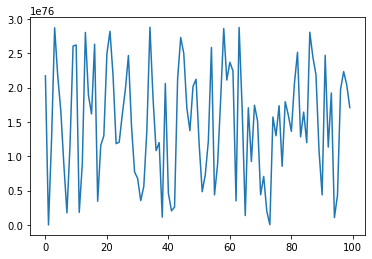

In [20]:
import matplotlib as mpl
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot([i for i in range(100)], [a_X(i) for i in range(100)])

Commit to the witness polynomials a,b,c as in the KZG commitment scheme. Notice from the scheme that $C = [p(x)]_1 = \sum_{i=0}^{deg(p(x))} [\tau^i] \cdot p_i$.

In [21]:
import functools as fp

# Remove initial zeros which sage adds in a polynomial coefficient list
def unpadded(l):
    while l[0] == 0:
        l.remove(0)
    return l

# Commit to a polynomial at the trusted setup value x, using generator g1
def commit_1(poly):
    Cp_1 = 0
    for i, p_i in enumerate(unpadded(poly.list())):
        Cp_1 += p_i * xs_1[i]
    return Cp_1

Ca_1 = commit_1(a_X)
Cb_1 = commit_1(b_X)
Cc_1 = commit_1(c_X)
    
(Ca_1, Cb_1, Cc_1)

(19034662415009058479184347153318385344301982335708195595885965760634568303217,
 5824090579493192090743480760885343764524543717484306048389376163771348495154,
 10478008216767012064342300700220966740778002592987924791407391627899896021286)

## Round 2

Compute Fiat-Shamir challenges $\beta, \gamma$. These would be randomly chosen values provided by the verifier but the Fiat-Shamir heuristic ensures the prover can't choose favorable values which would help them falsify the proof.

In [22]:
transcript = (Ca_1, Cb_1, Cc_1)
beta = hash(str(transcript) + '0')
gamma = hash(str(transcript) + '1')

beta = 13221126506858500342419753147213623108357776356575276450266108156614729463975
gamma = 21010720231774318035415855699715358516647461224162570325176355814698576594896

In [23]:
tmp='''
def f(j, k): return witness[j] + omega^(j) * k * beta + gamma
def g(j): return witness[j] + sigmastar(j) * beta + gamma

import math
witness = a + b + c

def f_abc(j): return f(j, 1) * f(n+j, k1) * f(2*n+j, k2)
def g_abc(j): return g(j) * g(n+j) * g(2*n+j)

# Final accumulator
def p(n): return math.prod([f_abc(j)/g_abc(j) for j in range(n)])

p(1)
'''

[(1, 1), (26389178552394651245246837090492411671330744266237564696174733440959711379620, 8635258211788802264125117385707320197296015322790459578648363330179716871732), (24682508875525884897641270952488416149830453149035712389703207095981135804695, 12819958874387992813128873355697572483711570458241863180193752642942920104527), (4855188899445002300170730717563617051094175372704778513906105166874447905568, 13572485941439203627593735964932339431483615315106852979374336807294992891415), (28948022309329048855892746252171976963363056481941647379679742748393362948096, 4383698272690798866791673917174139072858403540130448005714487648795909747885), (2558843756934397610645909161679565292032312215704082683505009307433651568477, 23471912862968415279160300502093763029151131360477123403514748704196847860964), (4265513433803163958251475299683560813532603332905934989976535652412227143402, 27063889546209494079272300163930594551355688365023134496965139593942667596652), (24092833409884046555722015534608359

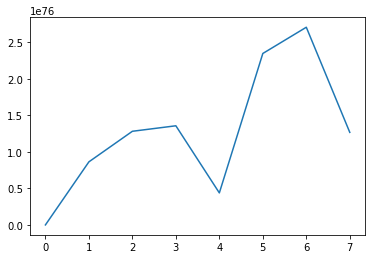

In [24]:
accumulator_points = [(1,1)]

'''
for j in range(1,n):
    x = omega^j
    acc = accumulator_points[j-1][1]
    
    acc *= witness[j] + omega^j * beta + gamma
    acc *= witness[n + j] + k1 * omega^j * beta + gamma
    acc *= witness[2*n + j] + k2 * omega^j * beta + gamma
    
    acc /= witness[j] + sigma_star[j] * beta + gamma
    acc /= witness[n + j] + sigma_star[n+j] * beta + gamma
    acc /= witness[2*n + j] + sigma_star[2*n+j] * beta + gamma
    
    accumulator_points.append((x,acc))
'''



accumulator_points = [(1, 1)]
for i in range(n - 1):
    x = omega^(i + 1)
    y = 1
    for j in range(i + 1):
        y *= witness[j] + beta * omega^j + gamma
        y *= witness[n + j] + beta * k1 * omega^j + gamma
        y *= witness[2 * n + j] + beta * k2 * omega^j + gamma
        y /= witness[j] + sigma_star[j] * beta + gamma
        y /= witness[n + j] + sigma_star[n + j] * beta + gamma
        y /= witness[2 * n + j] + sigma_star[2 * n + j] * beta + gamma
    accumulator_points.append((x, y))
    
print(accumulator_points)



fig, ax = plt.subplots()
ax.plot([i for i in range(n)], [y for _,y in accumulator_points])

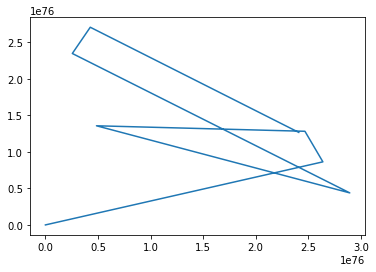

In [25]:
fig, ax = plt.subplots()
ax.plot([x for x,_ in accumulator_points], [y for _,y in accumulator_points])

In [26]:
# Blinding factor + 1 at omega + accumulator points at each index of witness values
z_X = (b7*X^2+b8*X+b9) * Z_H \
    + P.lagrange_polynomial(accumulator_points)

assert z_X(1) == 1

In [27]:
Cz_1 = commit_1(z_X)
Cz_1

27813185230427860934605396743964686932340257579332717714294143492607902226362

## Round 3

In round 3 the entire circuit - each row, the copy constraints, and the base case $\omega = 1$ are encoded in a single polynomial which is then split into three polynomials of degree < n, and each are commited to.

In [28]:
# Compute the new challenge
alpha = hash(str(Cz_1))
alpha

-3311998398108033334

In [29]:
circuit_X = (a_X*b_X*Qm_X + a_X*Ql_X + b_X*Qr_X + c_X*Qo_X + Qc_X)

zf_X = ((a_X + beta*X + gamma)
        * (b_X + beta*k1*X + gamma)
        * (c_X + beta*k2*X + gamma)
        * z_X)

gz_X = ((a_X + beta * sig1_X + gamma)
        * (b_X + beta * sig2_X + gamma)
        * (c_X + beta * sig3_X + gamma)
        * z_X(X * omega))

l1_X = P.lagrange_polynomial([(1, z_X(1)-1)] + [(omega^i, 0) for i in range(1,n)])

for i in range(n):
    assert zf_X(omega^i) == gz_X(omega^i)

Notice $P_{zf} - P_{gz}$ is the check b of step 5 in the permutation protocol in section 5; 

$Z(a)f(a) = g(a)Z(a \cdot g)$

L1z is check a;

$L_1(a)(Z(a) - 1) = 0$

In the following polynomial t, all three constraint checks are combined. Dividing by 0 at the roots of unity (Z_H) ensures that the constraints are also 0 or else the function is undefined.

In [30]:
t_X, rem_X = (circuit_X + (zf_X - gz_X) * alpha + l1_X * alpha^2).quo_rem(Z_H)

assert rem_X == 0
t_X

14638624451239004007464148155248437915001539141628681959356458918288675934197*X^29 + 5962103359923580735813700196011019743429854686846855039660472194797833848470*X^28 + 22298393478722959707377208714745888368074216080167420937090371309393340267908*X^27 + 19267789662937204522696292600454692685694967311125090270458691556808042838396*X^26 + 13170813823870247727785879157837934218079748208244775926344844427591344604339*X^25 + 1913533979685053178403054819318248800927631038340027289023015518295044087509*X^24 + 6489317132896428040886726767761461571487751752256213458920417183165535480242*X^23 + 25450305168266805319707968211990297534226922192916088156445966121337249688507*X^22 + 5482295275064424278333058224748872050344838528556447516212695378393501053513*X^21 + 20272360073757574752650027785025616530487566189576331029233887383691058622489*X^20 + 15646114024179752780232724261888888475455069478108045877522538160462022035660*X^19 + 156612540250340392805474296912621699531376135647108249187730655406822

Before commiting to t, notice that t has a much larger degree than n (the length of polynomials a,b,c). This is because many polynomials were multiplied together to get t (like $a \cdot b \cdot q_m$).

Remember in the the trusted setup, n+5 different exponentiations of the toxic waste value x are produced. Those values are used to commit to polynomials. Which means a commited polynomial can't be greater than degree n+5.

To fix t, split it into 3 sub-polynomials and commit to each.

In [31]:
coefs = t_X.list()
t_lo_X  = sum([coefs[i] * X^i for i in range(n+5)])
t_mid_X = sum([coefs[i] * X^i for i in range(n+5, 2*n+10)])
t_hi_X  = sum([coefs[i] * X^i for i in range(2*n+10, len(coefs))])

print(t_mid_X.list())
print(t_mid_X)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20290701959698172796793264037050732542504081047937225597648372900714088705578, 14351814045405767853810075292642982702714311644451306344614354451880550089153, 17276902789713786383424415156602370320161731660172121657053333951009885704345, 18362070351542797222634975644368316222928185744579500052324922914571614446633, 24722687436187485720718664735364323956910812046973669230623317938101571205614, 15661254025034039280547429691262169953137613564710824918773065540682245339044, 15646114024179752780232724261888888475455069478108045877522538160462022035660, 20272360073757574752650027785025616530487566189576331029233887383691058622489, 5482295275064424278333058224748872050344838528556447516212695378393501053513, 25450305168266805319707968211990297534226922192916088156445966121337249688507, 6489317132896428040886726767761461571487751752256213458920417183165535480242, 1913533979685053178403054819318248800927631038340027289023015518295044087509, 131708138238702

In [32]:
Ct_lo_1  = commit_1(t_lo_X)
Ct_mid_1 = commit_1(t_mid_X)
Ct_hi_1  = commit_1(t_hi_X)

## Round 4

In round 3 the final circuit constraint polynomial was constructed. All information about the faithful execution of the circuit is encoded in polynomial $t$.

In round 4 you will create an evaluation challenge $\delta=H(transcript)$, and use it to evaluate polynomials $a,b,c,s_{\sigma1},s_{\sigma2},s_{\sigma3}$ at $\delta$. Also evaluate polynomial $z=z(\delta \omega)$.

$\delta$ is the random point at which you are evaluating the polynomials to prove you have knowledge of them. See the [Schwartz-Zippel Lemma](https://en.wikipedia.org/wiki/Schwartz%E2%80%93Zippel_lemma) to understand why subtracting two polynomials and getting 0 at a random test point means they are probably equal.

In the KZG commitment scheme, you are proving $p(z) = y$. In Plonk, z here is the random point $\delta$. But of course what you really want to prove is that the circuit evaluated on secret inputs a,b produce hidden outputs c. Therefore the KZG polynomial p that you are proving an evaluation on in Plonk encodes not just the circuit but also the input and output relations themselves. The KZG evaluation proof $p(\delta) = y$ is instead using the Schwartz-Zippel lemma to say "polynomial actually exists and the prover has knowledge of it", and that polynomial encodes all the inputs, outputs, and execution of the circuit.

In [33]:
zeta = hash(str(Ct_lo_1) + str(Ct_mid_1) + str(Ct_hi_1))

In [34]:
ea = a_X(zeta)
eb = b_X(zeta)
ec = c_X(zeta)
ez = z_X(zeta)
esig1 = sig1_X(zeta)
esig2 = sig2_X(zeta)

## Round 5

In [37]:
v = hash('|'.join([str(ea) + str(eb) + str(ec) + str(ez) + str(esig1) + str(esig2)]))

In [39]:
r_X = ((ea*eb*Qm_X + ea*Ql_X + eb*Qr_X + ec*Qo_X + Qc_X)
       + (alpha * (ea + beta*zeta + gamma)
                * (eb + beta*k1*zeta + gamma)
                * (ec + beta*k2*zeta + gamma)) * z_X
       - ((ea + beta*esig1 + gamma)
          * (eb + beta*esig2 + gamma)
          * (ec + beta*sig3_X + gamma)) * ez
       - Z_H(zeta) * (t_lo_X + zeta^n * t_mid_X + zeta^(2*n) * t_hi_X))

In [40]:
r_X(omega)

7776309309352588222826020975655580564454101880645126536170219065503485051846